<h1> Introduction to Computer Vision (mainly convolutional nets) </h1>

The point of this notebook is to show you how to leverage one of the most powerful ideas in deep learning, namely convolutional neural networks. The state of the art models for virtually all tasks in computer vision are convolutional (although vision transformers have caught up in some cases). These models are also very relevant for deep learning with time series data.

The point is to make you comfortable with using convolutional nets as a tool in your machine learning toolbox. It is a very useful tool for any ML engineer or researcher, and they are surprisingly quick to implement when you know the basics.

The notebook starts by showing why we need convnets, and why they work. You will then experiment with the different layers usually found in these nets. After that, you will implement the following models:


1. Convolutional Net + Multilayer Perceptron for classification
2. Autoencoder for compression and unsupervised feature learning
3. U-Net for image segmentation
4. U-Net for generative diffusion modeling

The notebook is quite long and you are not meant to solve everything in one sitting.

In [1]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import Caltech101, OxfordIIITPet, CIFAR10
from torchvision import transforms
from pprint import pprint
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

/Users/eiriksteen/miniconda3/envs/cv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/eiriksteen/miniconda3/envs/cv/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


<h2> Why convolutional neural networks? </h2>

To understand this, we can start by seeing what happens when we use a standard fully connected network to model images. Let us start by fetching some images from Caltech. This is a classification dataset:

Files already downloaded and verified


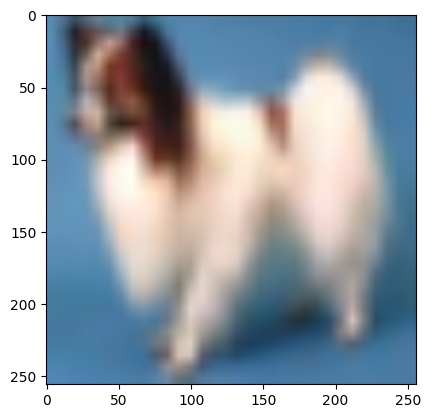

In [2]:
# data = Caltech101(
#     "data", 
#     download=True,
#     transform= transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256))])
# )

data = CIFAR10(
    "./data",
    train=True, 
    download=True,
    transform= transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256))])
)

# We retrieve a random sample from the dataset
image, _ = data[4000]

# We show the image. Note that we need to permute the image so that the shape is 
# (spatial_dim, spatial_dim, num_channels), instead of (num_channels, spatial_dim, spatial_dim)
# that Pytorch works with. All standard image processing libraries require the former shape.
plt.imshow(image.permute(1,2,0));

<h3> How much data is required to represent the image? </h3>

In [4]:
image.shape

torch.Size([3, 256, 256])

<h3> Overall, one image is represented by num_channels*height*width numbers </h3>

To have the image work with a fully connected net, we need to flatten it (since it expects the input as a vector):

In [3]:
image_flattened = image.flatten()
image_flattened.shape

torch.Size([196608])

<h3> Now we define an MLP to work with the flattened images: </h3>

In [6]:
image_size, hidden_size, num_labels = (196608, 196608//4, 101)

mlp = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_labels)
)

<h3> Now we do a standard forward and backward pass with the model: </h3>

In [4]:
# Split the data into batches
dataloader = DataLoader(data, batch_size=32)
# Get the first batch
images, labels = next(iter(dataloader))
# Flatten the images so that they work with the MLP
images_flat = images.flatten(start_dim=1)

In [ ]:
# Forward pass
preds = mlp(images_flat)
# Cross Entropy is a popular loss function for classification
loss_fn = nn.CrossEntropyLoss()
# We one hot encode the labels to facilitate loss computation
# This means that 4 becomes [0,0,0,0,1,0,0...]
y_true = F.one_hot(labels.long(), num_classes=101).float()
# Compute the loss
loss = loss_fn(y_true, preds)
# Backprop
loss.backward()

<h3> Your kernel probably crashed, and we conclude that running a MLP on large data such as raw images is a bad idea </h3>

Furthermore, MLPs are fundamentally non-sequential, meaning that the architecture does not take advantage of the spatial and sequential nature of images. This, as well as the computational problem that we just explored, motivates the need for an architecture that:

1. Avoids needing millions of parameters when working with images
2. Takes into account that image features are local (we look at patches to find patterns)
3. Takes into account that the same pattern can show up anywhere in an image

Convolutional nets solve all the above problems. 

<h2> The Convolutional Layer </h2>

Read this note for a concise intro to convolutional nets: https://inst.eecs.berkeley.edu/~cs182/sp23/assets/notes/scribe8.pdf (you can skip it if you feel comfortable with convnets). 

The main component of a CNN is the convolutional layer. As you read above, this layer consists of numerous filters where you basically take the dot product between the flattened filter and a flattened patch in the input image, and do this for all patches (where you set the patch size, the number of filters, and what patches to look at as the input). Let us now explore this layer in PyTorch.

First let's go through the parameters of a convolutional layer:
<br/>
1. in_channels
<br/>
<br/>
This is just the number of channels in the input. An image has 3 dimensions, num_channels, height, and width. We need to pass the num_channels of the input image.
<br/>
<br/>
2. out_channels
<br/>
<br/>
This defines how many channels the output will have. This is the same as how many different filters we have in the layer (each filter produces one output number, and we want out_channels output numbers per patch. We therefore need out_channels filters)
<br/>
<br/>
3. kernel_size
<br/>
<br/>
This defines the size of the filter, i.e, how large the patches we evaluate will be.
<br/>
<br/>
4. stride
<br/>
<br/>
This decides how far we slide the filter when we move from patch to patch. We can go to the next patch by moving one pixel to the right, or we can jump over some pixels instead. The stride number tells how far we jump (a value of 1 means we just go to the next pixel).
<br/>
<br/>
5. padding
<br/>
<br/>
We can add a frame of 0s to the image, in case we want to control the output shape, or to make sure that we don't miss a feature that appears in a corner or the side of an image. The padding decides how large the frame should be. For example:

Padding=0:
<br/>
X

Padding=1:
<br/>
000
<br/>
0X0
<br/>
000

Padding=2:
<br/>
00000
<br/>
00X00
<br/>
00000

In [5]:
# Let's once again print the shape of our images
images.shape

torch.Size([32, 3, 256, 256])

In [18]:
# We define the layer
# You can experiment with the parameters if you want
# The default is a classic strided convolution that halves the spatial dimension (due to the stride + padding)
conv = nn.Conv2d(
    in_channels=3, # we set it to 3 since there are 3 channels in the image
    out_channels=32, 
    kernel_size=3, 
    stride=2,
    padding=1
)

out = conv(images)
out.shape

torch.Size([32, 32, 128, 128])

<h3> Now build your own convolutional layer </h3>

In [20]:
class CustomConv:

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.weight = torch.random(out_channels, in_channels, kernel_size, kernel_size)


    def forward(self, x):

        # Go ham

        ...
        

def test_my_conv(in_channels, out_channels, kernel_size, stride, padding):

    image_rand = torch.random(32, in_channels, 256, 256)

    conv_torch = nn.Conv2d(
        in_channels=in_channels, 
        out_channels=out_channels, 
        kernel_size=kernel_size, 
        stride=stride,
        padding=padding
    )

    my_conv = CustomConv()
    my_conv.weight = conv_torch.weight.data

    out_real = conv_torch(image_rand)
    my_out = my_conv(image_rand)

    assert math.isclose(out_real.sum(), my_out.sum())

test_my_conv(
    in_channels=3, 
    out_channels=32, 
    kernel_size=3, 
    stride=2,
    padding=1)

torch.Size([32, 3, 3, 3])


<h2> Building a convolutional net for image classification </h2>
There are other layers that are frequently used with CNNs, and of course standard activation functions such as ReLU are necessary to learn nonlinear relationships here as well. One layer you can look into is the max pooling layer: https://paperswithcode.com/method/max-pooling. The output is just the max in the patch (this layer is actually not used that much in newer models, it's kind of old school). A very important class of layers is the normalization layer, but we will not go deep into the theory now. Batch normalization is a very powerful tool, and we recommend you use it in your models. 

Now we will build a convolutional net for image classification. This will show the standard capability of CNNs, namely learning image features. The model will consist of two components, one convolutional net to learn features in the data, and some model that uses the features to classify the input. The classification model can be anything, but it is normal to use a multilayer perceptron for this. Use Google if you want more information. Let's code it!

In [ ]:
class CNNClassifier(nn.Module):

    def __init__(self, in_channels: int = 3, num_classes: int = 101) -> None:
        super().__init__()

        # Define the convolutional net
        # I recommend 4 layers, using the parameters in the example above
        # You can use ReLU as your activation
        # Also, check out batch norm: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
        self.fcn = nn.Sequential(
            ...
        )

        # We must flatten the output from the convnet for use in the MLP
        # There is a convenient pytorch flatten layer, but you can do it how you want
        self.flatten = ...

        # The classification head, which can be anything. You could just use a linear model for example
        self.mlp = nn.Sequential(
            ...
        )

    def forward(self, x):

        # Code the forward pass

        ...

In [ ]:
def train_classifier(
        train_data,
        validation_data,
        model,
        num_epochs,
        lr,
        batch_size
    ):

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)
    # Cross Entropy is a very standard loss function for classification
    loss_fn = nn.CrossEntropyLoss()
    # AdamW is an enhanced version of gradient descent 
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(num_epochs):

        print(f"STARTING EPOCH {epoch+1}")
        model.train()
        train_loss = 0

        for batch in train_loader:

            images, labels = batch

            # Forward pass
            outputs = model(images)

            # We need to compute the loss and optimize the parameters of the model
            # To compute the loss, we need to one-hot encode the labels, 
            # similar to what we did in the sixth cell

            loss = ...

            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()

            train_loss += loss.item()
        

        model.eval()
        val_loss = 0
        total_labels, total_preds = [], []
        with torch.no_grad():
            for batch in validation_loader:

                images, labels = batch

                # Forward pass
                outputs = model(images)

                # You fill in the rest
                # You should also aggregate the predictions vs labels so we can compute the validation metrics
                # (its similar to the train loop, only we don't want to optimize the params)

                loss = ...

                val_loss += loss.item()

                # Go from one-hot to label index
                preds = torch.argmax(outputs, dim=1)

                total_labels += labels
                total_preds += preds

        metrics = {
            # Fill in your metrics (using total_labels and total_preds)
            # You should use the accuracy score, precision, recall, and f1 scores (Google is your friend)
            # The sklearn.metrics library includes implementations of most metrics
        }


train_data, validation_data = torch.utils.data.random_split(data, [0.8, 0.2])

model = CNNClassifier(in_channels=3, num_classes=101)

train_classifier(
    train_data, 
    validation_data, 
    model, 
    # The following are just some random hyperparams, feel free to change them
    num_epochs=25,
    lr=1e-03,
    batch_size=64
    )

<h2> The Residual Block </h2>

Before 2015, researchers discovered a strange phenomenom in deep convolutional networks. The performance on simple inputs started to degrade when making the convolutional nets deeper. Many were perplexed by this, as it was thought that the model should learn to just use what it knows about the simple patterns, and ignore what it has learnt about complex patterns, when the input is simple. 

What basically happens is that the model has caught all the patterns of the input before reaching the final layer, and when continuing through the next layers, the learned features become distorted. Some Microsoft researchers discovered a simple and highly efficient solution: skip the layers that aren't useful (https://arxiv.org/abs/1512.03385). This is done through residual blocks.

The mechanism behind residual blocks is very simple. Simply add the input untransformed by the block to the input transformed by the block, and return the sum! This let's you skip the block. Take a look at this for a short and sweet explanation/illustration: https://paperswithcode.com/method/residual-block#:~:text=Residual%20Blocks%20are%20skip%2Dconnection,part%20of%20the%20ResNet%20architecture. 

This block is used everywhere, so let us code it to keep in handy:



In [ ]:
class ResBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        # Code your block
        # I recommend conv + ReLU + batchnorm + dropout + conv + ReLU
        self.block = nn.Sequential(
            ...
        )

        # If in_channels != out_channels, you need to change the shape of the input
        # before summing it with the block output 
        self.adapt_shape = ...

    def forward(self, x):

        # Go
        ...

<h3> New let's redo the classifier as a Residual Network </h3>

In [ ]:
class ResnetClassifier(nn.Module):

    def __init__(self, in_channels: int = 3, num_classes: int = 101) -> None:
        super().__init__()


        # Use your Residual blocks.
        # I recommend keeping in_channels=out_channels for all the Residual Blocks,
        # and adding convolutional downsampling layers between the blocks.
        # With this scheme, the convolutions in the ResNet blocks should not alter the shape of the input.
        # But you can do what you want
        self.fcn = nn.Sequential(
            ...
        )

        self.flatten = ...

        self.mlp = nn.Sequential(
            ...
        )

    def forward(self, x):

        # Code the forward pass

        ...

In [ ]:
resnet = ResnetClassifier(3, 101)
# train_classifier(train_data, validation_data, resnet, ...)

<h1> Autoencoders </h1>

Now we are past the basic intro to CNNs that you can find everywhere, it is time to dig a little deeper.

Autoencoders are a class of models where you encode the image into a much lower dimensional vector (latent representation), that you then decode to reconstruct the original image. The idea is that a model able to compress an image into a very small vector, that can then be used to reconstruct the image, will lead to an informative feature representation in that vector (https://paperswithcode.com/method/autoencoder). It is also a nice compression algorithm. Now let's build it.

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self, in_channels: int, latent_dim: int) -> None:
        super().__init__()

        # Go ham.
        # I recommend using the resnet blocks 
        # (this can be identical to what you have in the ResnetClassifier)
        self.encoder = nn.Sequential(
            ...
        )

        # This network should basically be the inverse of the encoder.
        # To build this, you should look into transposed convolutions:
        # https://www.geeksforgeeks.org/what-is-transposed-convolutional-layer/
        # https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        # I recommend keeping in_channels=out_channels for the Res blocks as before, 
        # and then interleave the blocks with transposed convolutions
        self.decoder = nn.Sequential(
            ...
        )

    def forward(self, x):

        # Implement it 
        ...

In [ ]:
def train_ae(
        train_data,
        validation_data,
        model,
        num_epochs,
        lr,
        batch_size
    ):

    # Fill it in yourself
    # You can copy most of the classification training code in
    
    # We use the mean squared error loss since we are training a reconstruction model
    loss_func = nn.MSELoss()
    ...

<h3> Finally, there is something else called a Variational Autoencoder that is a much better than a standard AE, and it can easily be extended from this. You can look into it if you want. </h3>

<h1> The U-Net </h1>

Now let's move away from the task of image reconstruction, and turn to image segmentation. Image segmentation is pixelwise classification. For example, output 1 where the pixels show a dog in the image, and 0 else. The output shape is naturally the same as the input shape for this task.

You can use many different architectures for image segmentation, but (arguably) the best one is the U-Net. It takes its name from its shape, since it has a U shape. The autoencoder also has a U shape, and the networks are remarkably similar. There is only one difference: skip-connections.

Skip-connections are connections between a block in the encoder network, and the corresponding block in the decoder. The purpose of this connection is to not lose any information when downsampling and encoding the image (contrary to AEs, we don't want an information bottleneck. The point is not compression or feature learning; it is to detect interesting pixels in an image). There are many ways to implement this.

Take a look at this for a concise description of a U-Net: https://paperswithcode.com/method/u-net. Due to the similarities with an AE, you should be able to recycle most of the code. The only difference will be the skip-connections. 

In [ ]:
class UNet(nn.Module):

    def __init__(self, in_channels: int, out_classes: int) -> None:
        super().__init__()

        # Create your encoder.
        # Maybe it is best to create a separate class to handle
        # the skip-connections, instead of nn.Sequential?
        self.encoder = ...

        self.decoder = ...

    def forward(self, x):

        # Implement it 
        ...

<h3> We need a segmentation dataset to train this model. Let's use Oxford-IIIT Pets</h3>

In [ ]:
pets_dataset = OxfordIIITPet(
    "data", 
    target_types="segmentation", 
    # transform= transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256))]),
    download=True)

example_image, example_mask = pets_dataset[0]
example_mask = np.asarray(example_mask)

_, ax = plt.subplots(ncols=2)
ax[0].imshow(example_image)
ax[1].imshow(example_mask);

In [ ]:
def train_unet(
        train_data,
        validation_data,
        model,
        num_epochs,
        lr,
        batch_size
):
    # Fill it in yourself
    # It will be very similar to the classification training code
    ...

<h1> Diffusion </h1>

Let's do this next time